### XGBoost Modeling: 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- 为什么XGBoost表现普遍情况下好于普通的GBM?
    - Regularization, GBM has no Regularization to aovid overfitting.
    - Parallel processing, GBM has no paralle processing.
    - Flexible customrization, XGB allows more options for objective functions and evaluation metrics.
    - In-built routine to handle missing values. Although, all tree model could handl missing values, XGB could try different things to choose the appropriate path on each variable
    - Tree tunning, GBM stops if no gain obtained. But XGB goes till the max depth even if there in no positie gain and prunes back.
    - Built-in Cross-Validation. XGB implements CV at each iteration, while GBM has to run grid search.
    

- 什么样的数据最适合用XGBoost，什么样的数据不适合用XGBoost?
    
    
- XGBoost是如何并行的?
    There are three methonds to implement paralleling processing:
    - Parallelize Node Building at Each Level
    - Parallelize Split Finding on Each Node
    - Parallelize Split Finding at Each Level by Features
    
    
- 如何用XGBoost Package实现random forest？

### Hyper Parameter Tuning:

### Evaluation Performance between Logistic Regression and XGBoost:


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import time

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
train_freq_loans = pd.read_csv('./data/train_freq_loans.csv')
test_freq_loans = pd.read_csv('./data/test_freq_loans.csv')
print train_freq_loans.shape, test_freq_loans.shape

(86386, 196) (11170, 196)


In [3]:
test_freq_loans.columns

Index([u'loan_amnt', u'term', u'int_rate', u'installment', u'emp_length',
       u'annual_inc', u'dti', u'delinq_2yrs', u'inq_last_6mths',
       u'mths_since_last_delinq',
       ...
       u'107', u'108', u'109', u'110', u'111', u'112', u'emp_title', u'title',
       u'zip_code', u'loan_status'],
      dtype='object', length=196)

In [4]:
def xgb_fit(xgb_estimator, train_data, test_data, predictors, label, cv=True, cv_folds=3, early_stopping_rounds=50):
    """
    Function to fit the XGBoosting
    """
    start_time = time.time()

    if cv:
        params = xgb_estimator.get_xgb_params()
        train = xgb.DMatrix(train_data[predictors].values, label=train_data[label].values)
        cv_results = xgb.cv(params, train, num_boost_round=xgb_estimator.get_params()['n_estimators'], nfold=cv_folds, metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        xgb_estimator.set_params(n_estimators=cv_results.shape[0])
    
    # fit xgboosting on train data
    xgb_estimator.fit(train_data[predictors], train_data[label], eval_metric=['auc'])
        
    # predict the train data
    train_preds = xgb_estimator.predict(train_data[predictors])
    train_preds_proba = xgb_estimator.predict_proba(train_data[predictors])[:,1]
    
    # predict the test data
    test_preds = xgb_estimator.predict(test_data[predictors])
    test_preds_proba = xgb_estimator.predict_proba(test_data[predictors])[:,1]
    
    print("--- %s seconds ---" % (time.time() - start_time))
        
    # report model performance
    print "\nModel Performance"
    print "Accuracy : %.4g" % metrics.accuracy_score(train_data[label].values, train_preds)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(train_data[label], train_preds_proba)
    print "AUC Score (Test): %f" % metrics.roc_auc_score(test_data[label], test_preds_proba)
                    
    feature_importance = pd.Series(xgb_estimator.booster().get_fscore()).sort_values(ascending=False)
    feature_importance.to_csv('./data/feature_importance.csv')
    feature_importance.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    

### Tunning Process:
- Choose a relatively high learning rate. Generally a learning rate of 0.1(usually between 0.05 and 0.3)
- Tune tree-specific parameters like max_depth, min_child_weight, gamma, subsample, colsample_bytree
- Tune regularization parameters like lambda, alpha
- Lower the learning rate and decide the optimal parameters

### Step 1: find the number of estimators for a high learning rate

In [5]:
predictors = [x for x in train_freq_loans.columns if x not in ['loan_status']]

In [8]:
# max_depth = 5, min_child_weight = 1, gamma = 0, subsample, colsample_bytree = 0.8, scale_pos_weight = 1
xgb1 = XGBClassifier(learning_rate = 0.1, 
                     n_estimators=1000, 
                     max_depth=5, 
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8, 
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 131


--- 197.248671055 seconds ---

Model Performance
Accuracy : 0.8097
AUC Score (Train): 0.826138
AUC Score (Test): 0.822869


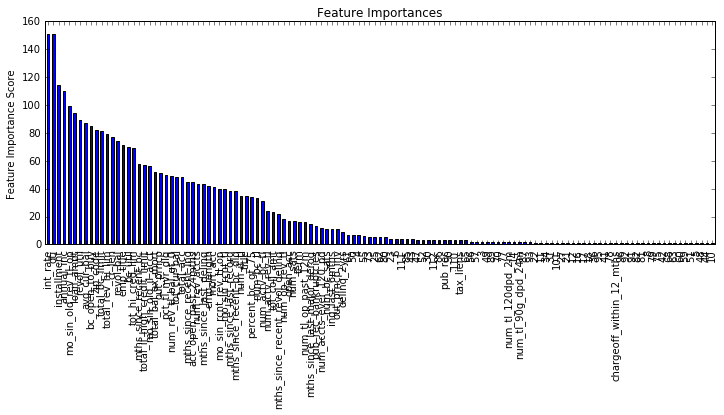

In [11]:
xgb_fit(xgb1, train_freq_loans, test_freq_loans, predictors, 'loan_status')

In [55]:
print 'best number of estimators: {}'.format(xgb1.n_estimators)

best number of estimators: 145


### Step 2: grid seach on max_depth and min_child_weight

In [6]:
param2 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

In [5]:
xgb2 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=145, 
                     max_depth=5,
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8,
                     objective= 'binary:logistic', 
                     nthread=8, 
                     scale_pos_weight=1, 
                     seed=27)

In [8]:
gsearch2 = GridSearchCV(estimator = xgb2, 
                        param_grid = param2, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [9]:
gsearch2.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=145, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [10]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78592, std: 0.01535, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.78602, std: 0.01529, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.78606, std: 0.01525, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.78632, std: 0.01511, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.78656, std: 0.01524, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.78714, std: 0.01470, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.78387, std: 0.01405, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.78383, std: 0.01499, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.78432, std: 0.01477, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.78048, std: 0.01518, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.78038, std: 0.01525, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.78043, std: 0.01411, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

### Step 3: grid seach on max_depth and min_child_weight deeper

In [6]:
param3 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch3 = GridSearchCV(estimator = xgb2, 
                        param_grid = param3, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [7]:
gsearch3.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=145, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [8]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.78713, std: 0.01544, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.78651, std: 0.01501, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.78679, std: 0.01528, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.78726, std: 0.01569, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.78722, std: 0.01553, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.78682, std: 0.01520, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.78557, std: 0.01569, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.78618, std: 0.01456, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.78616, std: 0.01503, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 4},
 0.78725595072977195)

### Step 4: grid search on min_child_weight

In [9]:
param4 = {
    'min_child_weight':[6,8,10,12]
}

In [10]:
xgb4 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=145, 
                     max_depth=5,
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8,
                     objective= 'binary:logistic', 
                     nthread=8, 
                     scale_pos_weight=1, 
                     seed=27)

In [11]:
gsearch4 = GridSearchCV(estimator = xgb4, 
                       param_grid = param4, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [12]:
gsearch4.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=145, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [13]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.78682, std: 0.01520, params: {'min_child_weight': 6},
  mean: 0.78739, std: 0.01524, params: {'min_child_weight': 8},
  mean: 0.78674, std: 0.01510, params: {'min_child_weight': 10},
  mean: 0.78721, std: 0.01482, params: {'min_child_weight': 12}],
 {'min_child_weight': 8},
 0.78738911444859871)

### Step5: grid search on gamma

In [14]:
param5 = {
    'gamma':[i/10.0 for i in range(0,5)]
}


In [15]:
xgb5 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=145, 
                     max_depth=5,
                     min_child_weight=8, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8,
                     objective= 'binary:logistic', 
                     nthread=8, 
                     scale_pos_weight=1, 
                     seed=27)

In [16]:
gsearch5 = GridSearchCV(estimator = xgb5, 
                       param_grid = param5, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=5)

In [17]:
gsearch5.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=8, missing=None, n_estimators=145, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [19]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.78859, std: 0.01699, params: {'gamma': 0.0},
  mean: 0.78850, std: 0.01688, params: {'gamma': 0.1},
  mean: 0.78850, std: 0.01688, params: {'gamma': 0.2},
  mean: 0.78851, std: 0.01679, params: {'gamma': 0.3},
  mean: 0.78851, std: 0.01680, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.78859058623657108)

### re-calibrate the number of boosting rounds for the updated parameters.

In [23]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=145,
        max_depth=5,
        min_child_weight=8,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 118



Model Performance
Accuracy : 0.8068
AUC Score (Train): 0.820163
AUC Score (Test): 0.824083


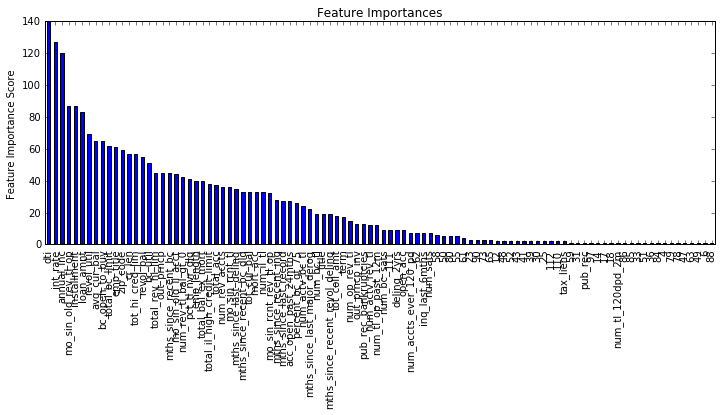

In [24]:
xgb_fit(xgb2, train_freq_loans, test_freq_loans, predictors, 'loan_status')

### We can see there are more features coming out as important

### Step 6: grid search subsample and colsample_bytree

In [26]:
xgb6 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=145,
        max_depth=5,
        min_child_weight=8,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

In [27]:
param6 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [28]:
gsearch6 = GridSearchCV(estimator = xgb6, 
                       param_grid = param6, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [29]:
gsearch6.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=8, missing=None, n_estimators=1000, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [30]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.77397, std: 0.01461, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.77456, std: 0.01514, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.77606, std: 0.01445, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.77808, std: 0.01396, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.77403, std: 0.01416, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.77466, std: 0.01609, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.77700, std: 0.01498, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.77716, std: 0.01574, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.77377, std: 0.01535, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.77373, std: 0.01471, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.77669, std: 0.01517, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.77769, std: 0.01433, params: {'subsample': 0.9, 'colsample_bytree'

### Step 7: grid search on reg_alpha

In [34]:
param7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [32]:
xgb7 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=145,
        max_depth=5,
        min_child_weight=8,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.9,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

In [35]:
gsearch7 = GridSearchCV(estimator = xgb7, 
                        param_grid = param7, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [36]:
gsearch7.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=8, missing=None, n_estimators=145, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.6),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [37]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.78645, std: 0.01476, params: {'reg_alpha': 1e-05},
  mean: 0.78656, std: 0.01471, params: {'reg_alpha': 0.01},
  mean: 0.78687, std: 0.01477, params: {'reg_alpha': 0.1},
  mean: 0.78664, std: 0.01536, params: {'reg_alpha': 1},
  mean: 0.78622, std: 0.01499, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.78687089197166082)

###  re-calibrate the number of boosting rounds for the updated parameters.

In [6]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=145,
        max_depth=5,
        min_child_weight=8,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

Will train until cv error hasn't decreased in 50 rounds.


--- 244.219191074 seconds ---

Model Performance
Accuracy : 0.8091
AUC Score (Train): 0.826112
AUC Score (Test): 0.821945


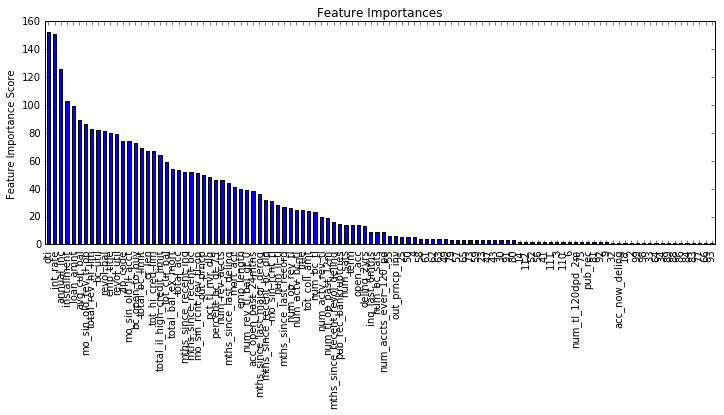

In [7]:
xgb_fit(xgb3, train_freq_loans, test_freq_loans, predictors, 'loan_status')

### Try a lower learning rate

In [50]:
xgb8 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=145,
        max_depth=5,
        min_child_weight=8,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

Will train until cv error hasn't decreased in 50 rounds.



Model Performance
Accuracy : 0.7938
AUC Score (Train): 0.782656
AUC Score (Test): 0.815694
--- 211.93392086 seconds ---


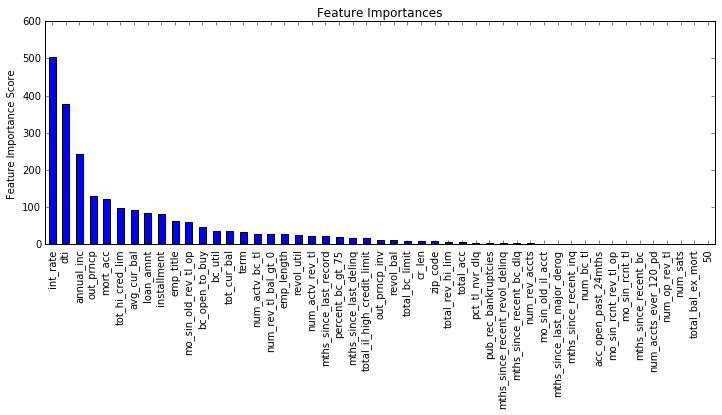

In [51]:
xgb_fit(xgb8, train_freq_loans, test_freq_loans, predictors, 'loan_status')

### Comparison XGB and Logistic Regression

In [52]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [53]:
start_time = time.time()
elasticNet = ElasticNet(alpha=0.001)
elasticNet.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])
preds = elasticNet.predict(test_freq_loans[predictors])
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_freq_loans['loan_status'], preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print "score: {}".format(roc_auc)
print("--- %s seconds ---" % (time.time() - start_time))

score: 0.803280811536
--- 2.55773615837 seconds ---


### Conclustion:
- The XGB has higher roc, improved from 0.803 to 0.815
- The XGB takes more time of 211 seconds than elasticNet of 2.6 seconds